In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)

## Read in data

In [2]:
df = pd.read_csv('collisions.csv', index_col=0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3,4,11,13,25,26,37,50,58,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
print(df.shape)
df.head()

(9172565, 74)


,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,81715.0,1941.0,11342,212,5,7.0,1941,0.0,0,not chp,NaN,not chp,003,PATTERSON ST,ATLANTIC AV,0.0,NaN,1.0,cloudy,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,property damage only,0.0,0.0,2.0,vehicle code violation,NaN,speeding,22350.0,NaN,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,NaN,daylight,none,0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,2020-03-14,07:45:00,2020-06-22
1,726202.0,3600.0,8945,064,5,5.0,3612,0.0,0,not chp,NaN,not chp,005,AMARGOSA,MARICOPA RD,0.0,NaN,NaN,clear,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,property damage only,0.0,0.0,1.0,vehicle code violation,NaN,speeding,22350.0,NaN,misdemeanor,hit object,fixed object,no pedestrian involved,dry,normal,NaN,dark with street lights,none,0,NaN,NaN,NaN,NaN,1.0,NaN,passenger car,1,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,2020-07-26,02:50:00,2020-09-30
2,3493128.0,9860.0,016616,NaN,2,9.0,3600,0.0,1,interstate,NaN,chp other,151,RT 15,LYTLE CREEK WASH,120.0,north,0.0,clear,NaN,1.0,SBD,8.0,15.0,NaN,NaN,13.10,highway,NaN,northbound,0.0,property damage only,0.0,0.0,2.0,vehicle code violation,NaN,improper turning,22107.0,NaN,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,NaN,daylight,none,1,NaN,NaN,NaN,1.0,1.0,NaN,other vehicle,47,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,2008-01-02,15:15:00,2008-08-20
3,3495044.0,9540.0,17076,NaN,1,9.0,1900,0.0,1,interstate,NaN,chp other,506,RT 5,RT 126,1000.0,south,0.0,clear,NaN,1.0,LA,7.0,5.0,NaN,R,55.29,highway,NaN,northbound,0.0,property damage only,0.0,0.0,2.0,vehicle code violation,NaN,speeding,22350.0,NaN,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,construction,NaN,daylight,none,1,NaN,NaN,NaN,1.0,1.0,NaN,truck or truck tractor,26,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,2008-01-02,11:30:00,2008-11-10
4,3503560.0,4316.0,15949,52,5,6.0,4316,0.0,0,not chp,NaN,not chp,005,RT 82,MATHILDA AV,30.0,west,0.0,clear,NaN,1.0,SCL,4.0,82.0,NaN,NaN,17.03,highway,NaN,northbound,0.0,property damage only,0.0,0.0,2.0,vehicle code violation,NaN,automobile right of way,21804.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,NaN,daylight,functioning,0,NaN,NaN,NaN,NaN,1.0,NaN,passenger car,7,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,2008-01-07,08:36:00,2008-09-23


## Preprocessing

### Fix NULL values

In [4]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

jurisdiction 10865
officer_id 22208
reporting_district 5418677
population 1659
special_condition 520483
city_division_lapd 8583900
chp_beat_class 2494
beat_number 794694
primary_road 25
secondary_road 17
distance 2
direction 2278778
intersection 93014
weather_1 44192
weather_2 8915555
state_highway_indicator 1574
caltrans_county 6625868
caltrans_district 6291894
state_route 6291895
route_suffix 8976336
postmile_prefix 8258482
postmile 6291896
location_type 6625870
ramp_intersection 8158489
side_of_highway 6625885
tow_away 57109
collision_severity 16
killed_victims 2052
injured_victims 2486
party_count 6
primary_collision_factor 54345
pcf_violation_code 8690891
pcf_violation_category 154249
pcf_violation 633216
pcf_violation_subsection 5887353
hit_and_run 1
type_of_collision 74298
motor_vehicle_involved_with 47594
pedestrian_action 6260
road_surface 78859
road_condition_1 76995
road_condition_2 9135225
lighting 52493
control_device 56310
chp_road_type 1
pedestrian_collision 8895182
bicy

In [5]:
def drop_missing_values(df, percentage):
    columns = df.columns
    percent_missing = df.isna().sum()*100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': columns, 'percent_missing': percent_missing})
    missing_drop = list(missing_value_df[missing_value_df['percent_missing'] > percentage].column_name)
    df = df.drop(missing_drop, axis=1)
    return df

# drop columns which have more than 60% null values
df = drop_missing_values(df, 60)
df.shape

(9172565, 51)

In [6]:
df.isna().sum()

case_id                                  0
jurisdiction                         10865
officer_id                           22208
reporting_district                 5418677
chp_shift                                0
population                            1659
county_city_location                     0
special_condition                   520483
beat_type                                0
chp_beat_type                            0
chp_beat_class                        2494
beat_number                         794694
primary_road                            25
secondary_road                          17
distance                                 2
direction                          2278778
intersection                         93014
weather_1                            44192
state_highway_indicator               1574
tow_away                             57109
collision_severity                      16
killed_victims                        2052
injured_victims                       2486
party_count

In [7]:
df.head()

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,special_condition,beat_type,chp_beat_type,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,state_highway_indicator,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_category,pcf_violation,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,chp_road_type,not_private_property,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,collision_date,collision_time,process_date
0,81715.0,1941.0,11342,212,5,7.0,1941,0.0,0,not chp,not chp,003,PATTERSON ST,ATLANTIC AV,0.0,NaN,1.0,cloudy,0.0,1.0,property damage only,0.0,0.0,2.0,vehicle code violation,speeding,22350.0,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0.0,2020-03-14,07:45:00,2020-06-22
1,726202.0,3600.0,8945,064,5,5.0,3612,0.0,0,not chp,not chp,005,AMARGOSA,MARICOPA RD,0.0,NaN,NaN,clear,0.0,1.0,property damage only,0.0,0.0,1.0,vehicle code violation,speeding,22350.0,misdemeanor,hit object,fixed object,no pedestrian involved,dry,normal,dark with street lights,none,0,1.0,passenger car,1,0,0,0,0,0,0,0,0,0.0,2020-07-26,02:50:00,2020-09-30
2,3493128.0,9860.0,016616,NaN,2,9.0,3600,0.0,1,interstate,chp other,151,RT 15,LYTLE CREEK WASH,120.0,north,0.0,clear,1.0,0.0,property damage only,0.0,0.0,2.0,vehicle code violation,improper turning,22107.0,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,1,1.0,other vehicle,47,0,0,0,0,0,0,0,0,0.0,2008-01-02,15:15:00,2008-08-20
3,3495044.0,9540.0,17076,NaN,1,9.0,1900,0.0,1,interstate,chp other,506,RT 5,RT 126,1000.0,south,0.0,clear,1.0,0.0,property damage only,0.0,0.0,2.0,vehicle code violation,speeding,22350.0,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,construction,daylight,none,1,1.0,truck or truck tractor,26,0,0,0,0,0,0,0,0,0.0,2008-01-02,11:30:00,2008-11-10
4,3503560.0,4316.0,15949,52,5,6.0,4316,0.0,0,not chp,not chp,005,RT 82,MATHILDA AV,30.0,west,0.0,clear,1.0,0.0,property damage only,0.0,0.0,2.0,vehicle code violation,automobile right of way,21804.0,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,daylight,functioning,0,1.0,passenger car,7,0,0,0,0,0,0,0,0,0.0,2008-01-07,08:36:00,2008-09-23


In [8]:
# drop non-relevant columns
df.drop(['case_id', 'jurisdiction', 'officer_id', 'reporting_district', 'chp_shift', 'population',
         'county_city_location', 'special_condition', 'beat_number', 'primary_road', 'secondary_road', 
         'direction', 'party_count', 'pcf_violation', 'not_private_property', 'collision_time', 
         'chp_vehicle_type_at_fault'], axis=1, inplace=True)

In [9]:
# fill null values
df['distance'] = df['distance'].fillna(0).astype('int')
df['intersection'] = df['intersection'].fillna(0).astype('int')
df['state_highway_indicator'] = df['state_highway_indicator'].fillna(0).astype('int')
df['tow_away'] = df['tow_away'].fillna(1).astype('int')
df['primary_collision_factor'] = df['primary_collision_factor'].fillna('vehicle code violation')
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('speeding')
df['hit_and_run'] = df['hit_and_run'].fillna('not hit and run')
df['type_of_collision'] = df['type_of_collision'].fillna('rear end')
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].fillna('other motor vehicle')
df['pedestrian_action'] = df['pedestrian_action'].fillna('no pedestrian involved')
df['road_surface'] = df['road_surface'].fillna('dry')
df['road_condition_1'] = df['road_condition_1'].fillna('normal')
df['lighting'] = df['lighting'].fillna('daylight')
df['control_device'] = df['control_device'].fillna('none')
df['statewide_vehicle_type_at_fault'] = df['statewide_vehicle_type_at_fault'].fillna('passenger car')
df['weather_1'] = df['weather_1'].fillna('clear')
df.head()

,beat_type,chp_beat_type,chp_beat_class,distance,intersection,weather_1,state_highway_indicator,tow_away,collision_severity,killed_victims,injured_victims,primary_collision_factor,pcf_violation_category,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,chp_road_type,statewide_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,collision_date,process_date
0,0,not chp,not chp,0,1,cloudy,0,1,property damage only,0.0,0.0,vehicle code violation,speeding,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0,passenger car,0,0,0,0,0,0,0,0,0.0,2020-03-14,2020-06-22
1,0,not chp,not chp,0,0,clear,0,1,property damage only,0.0,0.0,vehicle code violation,speeding,misdemeanor,hit object,fixed object,no pedestrian involved,dry,normal,dark with street lights,none,0,passenger car,0,0,0,0,0,0,0,0,0.0,2020-07-26,2020-09-30
2,1,interstate,chp other,120,0,clear,1,0,property damage only,0.0,0.0,vehicle code violation,improper turning,not hit and run,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,1,other vehicle,0,0,0,0,0,0,0,0,0.0,2008-01-02,2008-08-20
3,1,interstate,chp other,1000,0,clear,1,0,property damage only,0.0,0.0,vehicle code violation,speeding,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,construction,daylight,none,1,truck or truck tractor,0,0,0,0,0,0,0,0,0.0,2008-01-02,2008-11-10
4,0,not chp,not chp,30,0,clear,1,0,property damage only,0.0,0.0,vehicle code violation,automobile right of way,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,daylight,functioning,0,passenger car,0,0,0,0,0,0,0,0,0.0,2008-01-07,2008-09-23


In [10]:
df.isna().sum()

beat_type                             0
chp_beat_type                         0
chp_beat_class                     2494
distance                              0
intersection                          0
weather_1                             0
state_highway_indicator               0
tow_away                              0
collision_severity                   16
killed_victims                     2052
injured_victims                    2486
primary_collision_factor              0
pcf_violation_category                0
hit_and_run                           0
type_of_collision                     0
motor_vehicle_involved_with           0
pedestrian_action                     0
road_surface                          0
road_condition_1                      0
lighting                              0
control_device                        0
chp_road_type                         1
statewide_vehicle_type_at_fault       0
severe_injury_count                   0
other_visible_injury_count            0


In [11]:
def show_counts(column):
    print(df[column].value_counts())
    print('')
    print(df[column].unique())

In [12]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        print('column name:', col)
        print(show_counts(col))
        print('')

column name: chp_beat_class
not chp        4948276
chp other      3555987
chp primary     665808
Name: chp_beat_class, dtype: int64

['not chp' 'chp other' 'chp primary' nan]
None

column name: collision_severity
property damage only    5554474
pain                    2211590
other injury            1129820
severe injury            212607
fatal                     64056
N                             1
M                             1
Name: collision_severity, dtype: int64

['property damage only' 'other injury' 'pain' 'severe injury' 'fatal' nan
 'N' 'M']
None

column name: killed_victims
0.0     9106456
1.0       59103
2.0        3977
3.0         665
4.0         221
5.0          63
6.0          17
7.0           5
10.0          2
8.0           2
13.0          1
9.0           1
Name: killed_victims, dtype: int64

[ 0.  1.  2.  4.  3.  5.  9.  7.  6.  8. 10. 13. nan]
None

column name: injured_victims
0.0      5589321
1.0      2536494
2.0       710262
3.0       217820
4.0        73553
5.0

In [13]:
df['chp_beat_class'] = df['chp_beat_class'].fillna('not chp')
df['collision_severity'] = df['collision_severity'].fillna('property damage only')
df['killed_victims'] = df['killed_victims'].fillna(0.0).astype('int')
df['injured_victims'] = df['injured_victims'].fillna(0.0).astype('int')
df['chp_road_type'] = df['chp_road_type'].fillna(0)
df['motorcyclist_injured_count'] = df['motorcyclist_injured_count'].fillna(0.0).astype('int')

In [14]:
df.isna().sum()

beat_type                          0
chp_beat_type                      0
chp_beat_class                     0
distance                           0
intersection                       0
weather_1                          0
state_highway_indicator            0
tow_away                           0
collision_severity                 0
killed_victims                     0
injured_victims                    0
primary_collision_factor           0
pcf_violation_category             0
hit_and_run                        0
type_of_collision                  0
motor_vehicle_involved_with        0
pedestrian_action                  0
road_surface                       0
road_condition_1                   0
lighting                           0
control_device                     0
chp_road_type                      0
statewide_vehicle_type_at_fault    0
severe_injury_count                0
other_visible_injury_count         0
complaint_of_pain_injury_count     0
pedestrian_killed_count            0
p

### Label encode string features and target column

In [15]:
string_columns = []
for col in df.columns:
    if df[col].dtype == 'O':
        string_columns.append(col)
string_columns

['chp_beat_type',
 'chp_beat_class',
 'weather_1',
 'collision_severity',
 'primary_collision_factor',
 'pcf_violation_category',
 'hit_and_run',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'pedestrian_action',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'chp_road_type',
 'statewide_vehicle_type_at_fault',
 'collision_date',
 'process_date']

In [16]:
df['chp_road_type'].unique()

array([0, 1, 5, 6, 4, 7, 3, 2, '0', 'A'], dtype=object)

In [17]:
df = df[(df['chp_road_type'] != '0') & (df['chp_road_type'] != 'A')]
df['chp_road_type'].unique()

array([0, 1, 5, 6, 4, 7, 3, 2], dtype=object)

In [18]:
string_columns.remove('chp_road_type')

In [19]:
df['type_of_collision'].value_counts()

rear end      3121623
broadside     1805761
sideswipe     1623632
hit object    1474234
head-on        398264
other          249490
pedestrian     246089
overturned     245277
N                   1
O                   1
I                   1
Name: type_of_collision, dtype: int64

In [20]:
df = df[(df['type_of_collision'] != 'I') & 
        (df['type_of_collision'] != 'N') & 
        (df['type_of_collision'] != 'O')]

In [21]:
df['type_of_collision'].value_counts()

rear end      3121623
broadside     1805761
sideswipe     1623632
hit object    1474234
head-on        398264
other          249490
pedestrian     246089
overturned     245277
Name: type_of_collision, dtype: int64

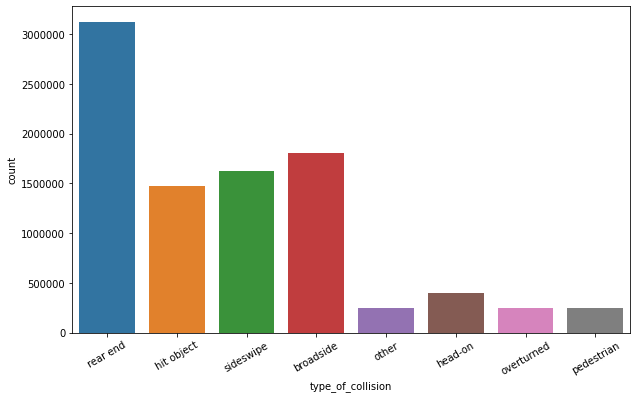

In [22]:
plt.figure(figsize=(10,6))
sns.countplot(df['type_of_collision'])
plt.xticks(rotation=30)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [23]:
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode

    def fit(self, x, y=None):
        return self # not relevant here

    def transform(self, x):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = x.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self, x, y=None):
        return self.fit(x, y).transform(x)

In [24]:
df_encoded = MultiColumnLabelEncoder(columns=string_columns).fit_transform(df)
df_encoded.head()

,beat_type,chp_beat_type,chp_beat_class,distance,intersection,weather_1,state_highway_indicator,tow_away,collision_severity,killed_victims,injured_victims,primary_collision_factor,pcf_violation_category,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,chp_road_type,statewide_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,collision_date,process_date
0,0,4,2,0,1,1,0,1,4,0,0,4,18,3,6,7,4,3,4,3,5,0,7,0,0,0,0,0,0,0,0,0,7012,5213
1,0,4,2,0,0,0,0,1,4,0,0,4,18,2,2,4,4,3,4,1,5,0,7,0,0,0,0,0,0,0,0,0,7146,5288
2,1,3,0,120,0,0,1,0,4,0,0,4,9,3,7,7,4,3,4,3,5,1,6,0,0,0,0,0,0,0,0,0,2557,1917
3,1,3,0,1000,0,0,1,0,4,0,0,4,18,3,6,7,4,3,0,3,5,1,13,0,0,0,0,0,0,0,0,0,2557,1981
4,0,4,2,30,0,0,1,0,4,0,0,4,1,3,0,7,4,3,4,3,4,0,7,0,0,0,0,0,0,0,0,0,2562,1940


In [25]:
df_encoded.drop(['collision_date', 'process_date'], axis=1, inplace=True)

In [26]:
print(df_encoded.shape)
df_encoded.head()

(9164370, 32)


,beat_type,chp_beat_type,chp_beat_class,distance,intersection,weather_1,state_highway_indicator,tow_away,collision_severity,killed_victims,injured_victims,primary_collision_factor,pcf_violation_category,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,chp_road_type,statewide_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count
0,0,4,2,0,1,1,0,1,4,0,0,4,18,3,6,7,4,3,4,3,5,0,7,0,0,0,0,0,0,0,0,0
1,0,4,2,0,0,0,0,1,4,0,0,4,18,2,2,4,4,3,4,1,5,0,7,0,0,0,0,0,0,0,0,0
2,1,3,0,120,0,0,1,0,4,0,0,4,9,3,7,7,4,3,4,3,5,1,6,0,0,0,0,0,0,0,0,0
3,1,3,0,1000,0,0,1,0,4,0,0,4,18,3,6,7,4,3,0,3,5,1,13,0,0,0,0,0,0,0,0,0
4,0,4,2,30,0,0,1,0,4,0,0,4,1,3,0,7,4,3,4,3,4,0,7,0,0,0,0,0,0,0,0,0


In [27]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9164370 entries, 0 to 9172564
Data columns (total 32 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   beat_type                        int64 
 1   chp_beat_type                    int64 
 2   chp_beat_class                   int64 
 3   distance                         int64 
 4   intersection                     int64 
 5   weather_1                        int64 
 6   state_highway_indicator          int64 
 7   tow_away                         int64 
 8   collision_severity               int64 
 9   killed_victims                   int64 
 10  injured_victims                  int64 
 11  primary_collision_factor         int64 
 12  pcf_violation_category           int64 
 13  hit_and_run                      int64 
 14  type_of_collision                int64 
 15  motor_vehicle_involved_with      int64 
 16  pedestrian_action                int64 
 17  road_surface               

In [28]:
df_encoded['chp_road_type'] = df_encoded['chp_road_type'].astype('int')

In [29]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9164370 entries, 0 to 9172564
Data columns (total 32 columns):
 #   Column                           Dtype
---  ------                           -----
 0   beat_type                        int64
 1   chp_beat_type                    int64
 2   chp_beat_class                   int64
 3   distance                         int64
 4   intersection                     int64
 5   weather_1                        int64
 6   state_highway_indicator          int64
 7   tow_away                         int64
 8   collision_severity               int64
 9   killed_victims                   int64
 10  injured_victims                  int64
 11  primary_collision_factor         int64
 12  pcf_violation_category           int64
 13  hit_and_run                      int64
 14  type_of_collision                int64
 15  motor_vehicle_involved_with      int64
 16  pedestrian_action                int64
 17  road_surface                     int64
 18  ro

In [30]:
x = df_encoded.drop('type_of_collision', axis=1)
y = df_encoded['type_of_collision'] # will be predicting the type of collision
print(x.shape, y.shape)

(9164370, 31) (9164370,)


## Split the data into training and testing sets

In [31]:
# 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [32]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7331496, 31) (7331496,)
(1832874, 31) (1832874,)


In [33]:
pd.DataFrame(x_test).to_csv('x_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

## Train an XGB classifier

In [34]:
# xgb = XGBClassifier()
# xgb.fit(x_train, y_train)
# pickle.dump(xgb, open('baseline_model.sav', 'wb'))

In [35]:
# load in trained model
model = pickle.load(open('baseline_model.sav', 'rb'))

In [36]:
y_pred = model.predict(x_test)

In [45]:
encoder = LabelEncoder()
encoder.fit(df['type_of_collision'])

LabelEncoder()

In [47]:
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

   broadside       0.74      0.80      0.77    360756
     head-on       0.55      0.08      0.13     79546
  hit object       0.89      0.97      0.93    295204
       other       0.55      0.30      0.39     49804
  overturned       0.88      0.75      0.81     48864
  pedestrian       0.88      0.95      0.91     49147
    rear end       0.83      0.87      0.85    625162
   sideswipe       0.67      0.70      0.68    324391

    accuracy                           0.79   1832874
   macro avg       0.75      0.68      0.68   1832874
weighted avg       0.78      0.79      0.77   1832874



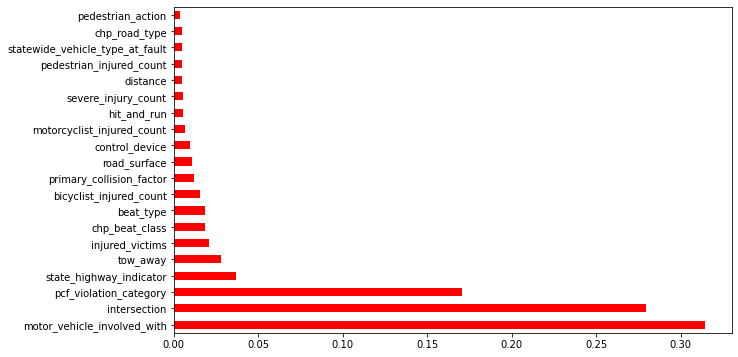

In [49]:
feat_importances = pd.Series(model.feature_importances_, index=pd.DataFrame(x_test).columns)
plt.figure(figsize=(10,6))
feat_importances.nlargest(20).plot(kind='barh', color='red')
plt.show()

## PCA to reduce the number of features

In [50]:
scaler = MinMaxScaler() 
x_scaled = scaler.fit_transform(x)
pca = PCA()
pca.fit(x_scaled)

PCA()

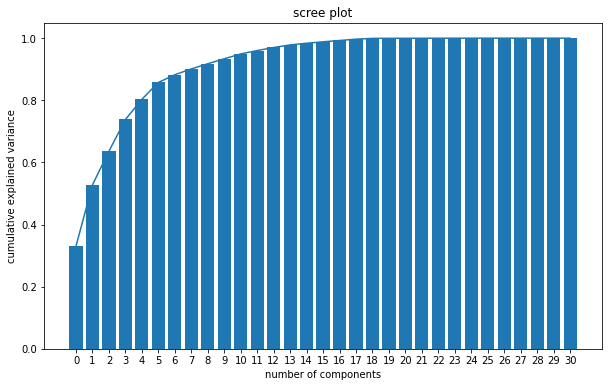

In [54]:
evr = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,6))
plt.plot(evr)
plt.bar(np.arange(0, len(evr)), evr)
plt.xticks(np.arange(0, len(evr), 1))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('scree plot')
plt.show()

It seems that 19 of the components explain 100% of the variance.

In [56]:
pca = PCA(n_components=19)
x = pca.fit_transform(x)
x.shape

(9164370, 19)

## Train and save the model that uses principal components

In [57]:
# 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7331496, 19) (7331496,)
(1832874, 19) (1832874,)


In [ ]:
pca_xgb = XGBClassifier()
pca_xgb.fit(x_train, y_train)
pickle.dump(pca_xgb, open('pca_model.sav', 'wb'))

[18:21:45] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
# load in pca model
pca_model = pickle.load(open('pca_model.sav', 'rb'))

In [ ]:
y_pred_pca = pca_model.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_pca), target_names=encoder.classes_)

In [ ]:
feat_importances = pd.Series(pca_model.feature_importances_, index=pd.DataFrame(x_test).columns)
plt.figure(figsize=(10,6))
feat_importances.nlargest(15).plot(kind='barh', color='red')
plt.show()